In [1]:
pip install keras-resnet
# 현재 성능 70%에 가까운건 학습을 2번 시켜서 그런듯. 이거 pull 받아서 학습시킬거면 epoch를 100번은 해야 할 것 같아요...!

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras_resnet.models import ResNet18
import numpy as np
from PIL import Image, UnidentifiedImageError


In [3]:
# 데이터 준비 함수
def prepare_data(dataset_path, categories, num_samples_per_category=400):
    filepaths, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):
            all_files = [file for file in os.listdir(category_path) if file.endswith(('jpg', 'jpeg', 'png', '.jfif'))]
            sampled_files = np.random.choice(all_files, min(num_samples_per_category, len(all_files)), replace=False)
            for file in sampled_files:
                file_path = os.path.join(category_path, file)
                try:
                    # 이미지 파일이 열리는지 확인
                    with Image.open(file_path) as img:
                        img.verify()  # 파일이 손상되지 않았는지 확인
                    filepaths.append(file_path)
                    labels.append(category)
                except (UnidentifiedImageError, IOError):
                    print(f"Skipping corrupted image file: {file_path}")
    return filepaths, labels


# 경로와 카테고리 정의
data_path = "../../raw_data_new"
categories = ["blue_jellyfish", "barrel_jellyfish", "compass_jellyfish",
              "lions_mane_jellyfish", "mauve_stinger_jellyfish", "moon_jellyfish"]

In [4]:
# 데이터 준비
filepaths, labels = prepare_data(data_path, categories)

# DataFrame 생성
data = pd.DataFrame({'filename': filepaths, 'class': labels})

# Train/Test 분리
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=42)

# Train/Validation 분리
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)

In [5]:
# 데이터 증강 설정 (옵션 강화)
augmentation_generator = ImageDataGenerator(
    rotation_range=30,           # 회전 범위 증가
    width_shift_range=0.3,       # 가로 이동 범위 증가
    height_shift_range=0.3,      # 세로 이동 범위 증가
    shear_range=0.3,             # 전단 변환 범위 증가
    zoom_range=0.3,              # 확대/축소 범위 증가
    brightness_range=[0.7, 1.3], # 밝기 조정 추가
    horizontal_flip=True,        # 좌우 반전
    vertical_flip=True,          # 상하 반전 추가
    fill_mode='nearest'          # 채움 모드
)


In [6]:
# flow_from_dataframe 설정
def create_data_generator(generator, dataframe, target_size, batch_size):
    return generator.flow_from_dataframe(
        dataframe,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

# 이미지 크기와 배치 사이즈 설정
img_height, img_width = 224, 224
batch_size = 16

In [7]:
# 데이터 제너레이터 생성
train_generator = create_data_generator(augmentation_generator, train_df, (img_height, img_width), batch_size)
val_generator = create_data_generator(augmentation_generator, val_df, (img_height, img_width), batch_size)
test_generator = create_data_generator(augmentation_generator, test_df, (img_height, img_width), batch_size)

# 클래스 수 정의
num_classes = len(categories)

Found 1462 validated image filenames belonging to 6 classes.
Found 361 validated image filenames belonging to 6 classes.
Found 450 validated image filenames belonging to 6 classes.


/opt/conda/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 74 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 23 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 30 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [8]:
# ResNet18 모델 생성
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
resnet18 = ResNet18(inputs, classes=num_classes)

In [13]:
# 모델 컴파일
learning_rate = 0.001
resnet18.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# 모델 훈련
epochs = 30
try:
    history = resnet18.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        verbose=1  # 진행 상태 출력
    )
except UnidentifiedImageError as e:
    print(f"Error during training: {e}")

Epoch 1/30
92/92 [==============================] - 44s 455ms/step - loss: 1.0277 - accuracy: 0.6135 - val_loss: 1.9462 - val_accuracy: 0.5097
Epoch 2/30
92/92 [==============================] - 43s 462ms/step - loss: 1.0327 - accuracy: 0.6218 - val_loss: 1.2539 - val_accuracy: 0.5429
Epoch 3/30
92/92 [==============================] - 36s 390ms/step - loss: 1.0607 - accuracy: 0.6081 - val_loss: 1.2405 - val_accuracy: 0.5623
Epoch 4/30
92/92 [==============================] - 35s 384ms/step - loss: 0.9567 - accuracy: 0.6464 - val_loss: 1.1894 - val_accuracy: 0.5540
Epoch 5/30
92/92 [==============================] - 44s 477ms/step - loss: 0.9783 - accuracy: 0.6457 - val_loss: 1.1679 - val_accuracy: 0.6094
Epoch 6/30
92/92 [==============================] - 41s 445ms/step - loss: 0.9488 - accuracy: 0.6464 - val_loss: 2.0480 - val_accuracy: 0.4127
Epoch 7/30
92/92 [==============================] - 40s 437ms/step - loss: 0.9242 - accuracy: 0.6505 - val_loss: 1.3161 - val_accuracy: 0.5762

In [14]:
# 모델 저장
resnet18.save('../ipynb_files/output_models/resnet18.h5')

In [15]:
# 테스트 평가
try:
    test_loss, test_acc = resnet18.evaluate(test_generator, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")
except UnidentifiedImageError as e:
    print(f"Error during evaluation: {e}")

Test Loss: 0.9306, Test Accuracy = 0.6978


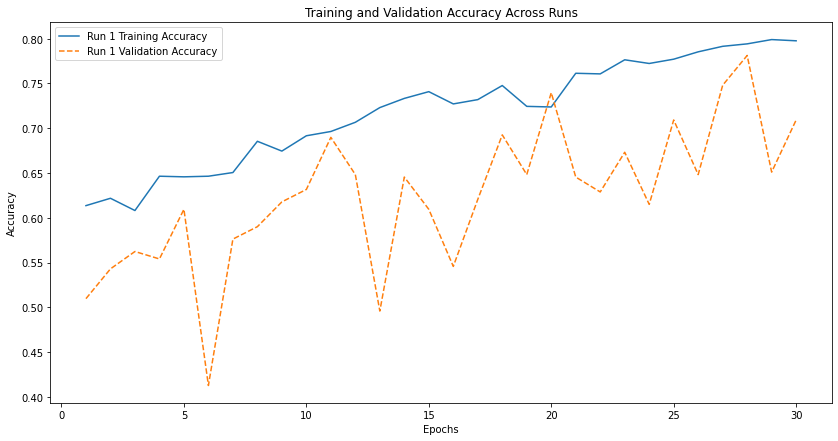

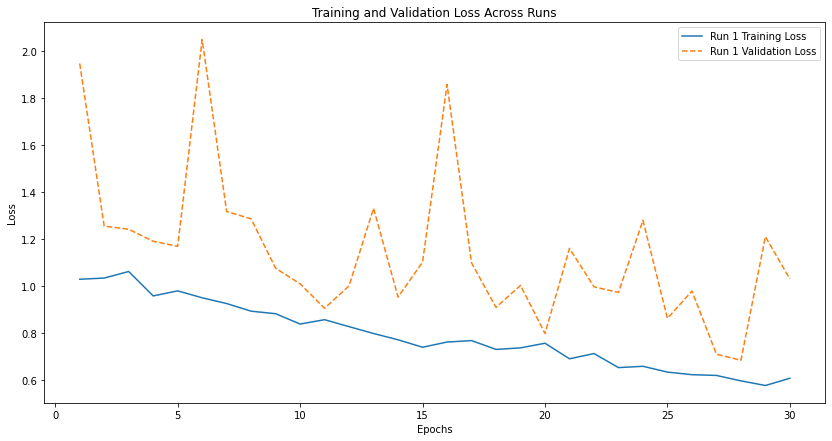

In [16]:
# 시각화를 위한 데이터 저장용 리스트
all_train_acc = [history.history['accuracy']]
all_val_acc = [history.history['val_accuracy']]
all_train_loss = [history.history['loss']]
all_val_loss = [history.history['val_loss']]

# 결과 시각화 함수
def plot_comparison(all_train_acc, all_val_acc, all_train_loss, all_val_loss):
    epochs_range = range(1, epochs + 1)
    
    # Accuracy 그래프
    plt.figure(figsize=(14, 7))
    
    # Training Accuracy
    for i, train_acc in enumerate(all_train_acc):
        plt.plot(epochs_range, train_acc, label=f'Run {i+1} Training Accuracy')
    # Validation Accuracy
    for i, val_acc in enumerate(all_val_acc):
        plt.plot(epochs_range, val_acc, linestyle='--', label=f'Run {i+1} Validation Accuracy')
    
    plt.title('Training and Validation Accuracy Across Runs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss 그래프
    plt.figure(figsize=(14, 7))
    
    # Training Loss
    for i, train_loss in enumerate(all_train_loss):
        plt.plot(epochs_range, train_loss, label=f'Run {i+1} Training Loss')
    # Validation Loss
    for i, val_loss in enumerate(all_val_loss):
        plt.plot(epochs_range, val_loss, linestyle='--', label=f'Run {i+1} Validation Loss')
    
    plt.title('Training and Validation Loss Across Runs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 결과 시각화 호출
plot_comparison(all_train_acc, all_val_acc, all_train_loss, all_val_loss)